In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plot
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
batch_size = 32
X_dim = 784
z_dim = 16
c_dim = 10
h_dim = 256

In [3]:
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)

Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
def plot_images(samples):
    fig = plot.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plot.subplot(gs[i])
        plot.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plot.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [5]:
def xavier_init(size):
    input_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(input_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [6]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])

D_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]


z = tf.placeholder(tf.float32, shape=[None, z_dim])
c = tf.placeholder(tf.float32, shape=[None, c_dim])

G_W1 = tf.Variable(xavier_init([z_dim + c_dim, h_dim // 2]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim // 2]))

G_W2 = tf.Variable(xavier_init([h_dim // 2, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

Q_W1 = tf.Variable(xavier_init([X_dim, h_dim // 2]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim // 2]))

Q_W2 = tf.Variable(xavier_init([h_dim // 2, 10]))
Q_b2 = tf.Variable(tf.zeros(shape=[10]))

theta_Q = [Q_W1, Q_W2, Q_b1, Q_b2]

In [7]:
def get_sample_z(size):
    return np.random.uniform(-1., 1., size=size)

In [8]:
def get_sample_c(m):
    return np.random.multinomial(1, 10*[0.1], size=m)

In [9]:
def generator(z, c):
    inputs = tf.concat(axis=1, values=[z, c])
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_out = tf.sigmoid(tf.matmul(G_h1, G_W2) + G_b2)
    return G_out

In [10]:
def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_out = tf.sigmoid(tf.matmul(D_h1, D_W2) + D_b2)
    return D_out

In [11]:
def Q(x):
    Q_h1 = tf.nn.relu(tf.matmul(x, Q_W1) + Q_b1)
    Q_out = tf.nn.softmax(tf.matmul(Q_h1, Q_W2) + Q_b2)
    return Q_out

In [12]:
generator_sample = generator(z, c)
discriminator_real = discriminator(X)
discriminator_fake = discriminator(generator_sample)
q_c_x = Q(generator_sample)

In [13]:
d_loss = -tf.reduce_mean(tf.log(discriminator_real + 1e-8) + tf.log(1 - discriminator_fake + 1e-8))
g_loss = -tf.reduce_mean(tf.log(discriminator_fake + 1e-8))
q_loss = tf.reduce_mean(-tf.reduce_sum(tf.log(q_c_x + 1e-8) * c, 1)) + \
            tf.reduce_mean(-tf.reduce_sum(tf.log(c + 1e-8) * c, 1))

In [14]:
d_step = tf.train.AdamOptimizer(0.0001).minimize(d_loss, var_list=theta_D)
g_step = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=theta_G)
q_step = tf.train.AdamOptimizer(0.0001).minimize(q_loss, var_list=theta_G + theta_Q)

In [15]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

Iteration: 0 - Discriminator Loss: 1.758, Generator Loss: 0.5035


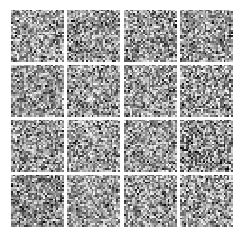

Iteration: 100 - Discriminator Loss: 0.07233, Generator Loss: 4.118
Iteration: 200 - Discriminator Loss: 0.04022, Generator Loss: 4.65
Iteration: 300 - Discriminator Loss: 0.01797, Generator Loss: 5.631
Iteration: 400 - Discriminator Loss: 0.0187, Generator Loss: 6.048
Iteration: 500 - Discriminator Loss: 0.02722, Generator Loss: 6.339
Iteration: 600 - Discriminator Loss: 0.04986, Generator Loss: 6.34
Iteration: 700 - Discriminator Loss: 0.1594, Generator Loss: 5.25
Iteration: 800 - Discriminator Loss: 0.1709, Generator Loss: 3.883
Iteration: 900 - Discriminator Loss: 0.179, Generator Loss: 3.692
Iteration: 1000 - Discriminator Loss: 0.156, Generator Loss: 3.423


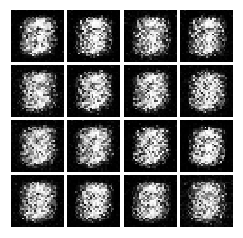

Iteration: 1100 - Discriminator Loss: 0.1521, Generator Loss: 3.417
Iteration: 1200 - Discriminator Loss: 0.1008, Generator Loss: 3.361
Iteration: 1300 - Discriminator Loss: 0.1059, Generator Loss: 3.289
Iteration: 1400 - Discriminator Loss: 0.1021, Generator Loss: 3.078
Iteration: 1500 - Discriminator Loss: 0.09038, Generator Loss: 3.105
Iteration: 1600 - Discriminator Loss: 0.1425, Generator Loss: 3.053
Iteration: 1700 - Discriminator Loss: 0.161, Generator Loss: 2.564
Iteration: 1800 - Discriminator Loss: 0.2102, Generator Loss: 2.544
Iteration: 1900 - Discriminator Loss: 0.3241, Generator Loss: 2.374
Iteration: 2000 - Discriminator Loss: 0.1479, Generator Loss: 2.29


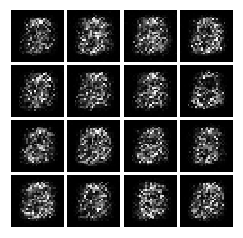

Iteration: 2100 - Discriminator Loss: 0.1944, Generator Loss: 2.33
Iteration: 2200 - Discriminator Loss: 0.2451, Generator Loss: 2.095
Iteration: 2300 - Discriminator Loss: 0.1785, Generator Loss: 2.181
Iteration: 2400 - Discriminator Loss: 0.2068, Generator Loss: 2.136
Iteration: 2500 - Discriminator Loss: 0.2086, Generator Loss: 2.299
Iteration: 2600 - Discriminator Loss: 0.1729, Generator Loss: 2.258
Iteration: 2700 - Discriminator Loss: 0.2348, Generator Loss: 2.071
Iteration: 2800 - Discriminator Loss: 0.2057, Generator Loss: 2.294
Iteration: 2900 - Discriminator Loss: 0.246, Generator Loss: 2.47
Iteration: 3000 - Discriminator Loss: 0.2281, Generator Loss: 2.344


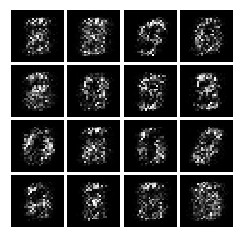

Iteration: 3100 - Discriminator Loss: 0.2561, Generator Loss: 2.373
Iteration: 3200 - Discriminator Loss: 0.1922, Generator Loss: 2.398
Iteration: 3300 - Discriminator Loss: 0.3502, Generator Loss: 2.188
Iteration: 3400 - Discriminator Loss: 0.1568, Generator Loss: 2.603
Iteration: 3500 - Discriminator Loss: 0.2293, Generator Loss: 2.94
Iteration: 3600 - Discriminator Loss: 0.2015, Generator Loss: 2.592
Iteration: 3700 - Discriminator Loss: 0.2065, Generator Loss: 2.702
Iteration: 3800 - Discriminator Loss: 0.2613, Generator Loss: 2.684
Iteration: 3900 - Discriminator Loss: 0.1464, Generator Loss: 2.815
Iteration: 4000 - Discriminator Loss: 0.1811, Generator Loss: 2.946


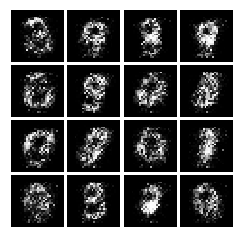

Iteration: 4100 - Discriminator Loss: 0.2545, Generator Loss: 2.657
Iteration: 4200 - Discriminator Loss: 0.1773, Generator Loss: 2.848
Iteration: 4300 - Discriminator Loss: 0.2541, Generator Loss: 2.942
Iteration: 4400 - Discriminator Loss: 0.2089, Generator Loss: 3.101
Iteration: 4500 - Discriminator Loss: 0.197, Generator Loss: 2.47
Iteration: 4600 - Discriminator Loss: 0.1879, Generator Loss: 2.642
Iteration: 4700 - Discriminator Loss: 0.199, Generator Loss: 2.837
Iteration: 4800 - Discriminator Loss: 0.2108, Generator Loss: 2.78
Iteration: 4900 - Discriminator Loss: 0.1384, Generator Loss: 3.135
Iteration: 5000 - Discriminator Loss: 0.2818, Generator Loss: 2.233


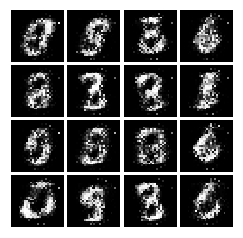

Iteration: 5100 - Discriminator Loss: 0.1747, Generator Loss: 2.941
Iteration: 5200 - Discriminator Loss: 0.1992, Generator Loss: 3.423
Iteration: 5300 - Discriminator Loss: 0.1557, Generator Loss: 2.979
Iteration: 5400 - Discriminator Loss: 0.1748, Generator Loss: 2.931
Iteration: 5500 - Discriminator Loss: 0.2172, Generator Loss: 2.866
Iteration: 5600 - Discriminator Loss: 0.1505, Generator Loss: 3.054
Iteration: 5700 - Discriminator Loss: 0.2849, Generator Loss: 2.481
Iteration: 5800 - Discriminator Loss: 0.1381, Generator Loss: 3.215
Iteration: 5900 - Discriminator Loss: 0.2036, Generator Loss: 3.303
Iteration: 6000 - Discriminator Loss: 0.1814, Generator Loss: 3.151


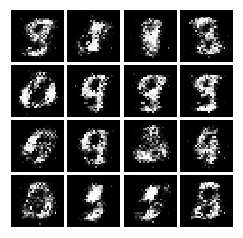

Iteration: 6100 - Discriminator Loss: 0.1483, Generator Loss: 3.486
Iteration: 6200 - Discriminator Loss: 0.193, Generator Loss: 3.016
Iteration: 6300 - Discriminator Loss: 0.1984, Generator Loss: 2.925
Iteration: 6400 - Discriminator Loss: 0.1339, Generator Loss: 3.319
Iteration: 6500 - Discriminator Loss: 0.2655, Generator Loss: 2.59
Iteration: 6600 - Discriminator Loss: 0.1891, Generator Loss: 3.185
Iteration: 6700 - Discriminator Loss: 0.1606, Generator Loss: 2.708
Iteration: 6800 - Discriminator Loss: 0.2294, Generator Loss: 2.897
Iteration: 6900 - Discriminator Loss: 0.1691, Generator Loss: 2.747
Iteration: 7000 - Discriminator Loss: 0.2777, Generator Loss: 2.876


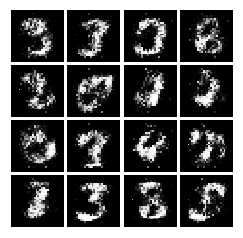

Iteration: 7100 - Discriminator Loss: 0.1774, Generator Loss: 3.103
Iteration: 7200 - Discriminator Loss: 0.1245, Generator Loss: 3.321
Iteration: 7300 - Discriminator Loss: 0.2611, Generator Loss: 2.683
Iteration: 7400 - Discriminator Loss: 0.21, Generator Loss: 2.604
Iteration: 7500 - Discriminator Loss: 0.1465, Generator Loss: 3.348
Iteration: 7600 - Discriminator Loss: 0.2354, Generator Loss: 3.123
Iteration: 7700 - Discriminator Loss: 0.1895, Generator Loss: 2.832
Iteration: 7800 - Discriminator Loss: 0.1967, Generator Loss: 2.844
Iteration: 7900 - Discriminator Loss: 0.1813, Generator Loss: 3.016
Iteration: 8000 - Discriminator Loss: 0.1357, Generator Loss: 3.385


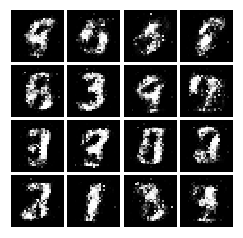

Iteration: 8100 - Discriminator Loss: 0.2375, Generator Loss: 3.008
Iteration: 8200 - Discriminator Loss: 0.1334, Generator Loss: 3.334
Iteration: 8300 - Discriminator Loss: 0.1839, Generator Loss: 3.406
Iteration: 8400 - Discriminator Loss: 0.229, Generator Loss: 3.052
Iteration: 8500 - Discriminator Loss: 0.101, Generator Loss: 3.616
Iteration: 8600 - Discriminator Loss: 0.1953, Generator Loss: 2.512
Iteration: 8700 - Discriminator Loss: 0.1953, Generator Loss: 3.285
Iteration: 8800 - Discriminator Loss: 0.2224, Generator Loss: 2.724
Iteration: 8900 - Discriminator Loss: 0.1423, Generator Loss: 3.3
Iteration: 9000 - Discriminator Loss: 0.1842, Generator Loss: 2.99


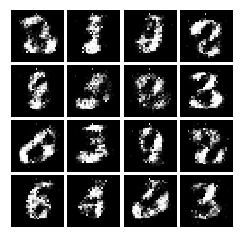

Iteration: 9100 - Discriminator Loss: 0.2629, Generator Loss: 3.356
Iteration: 9200 - Discriminator Loss: 0.2205, Generator Loss: 2.707
Iteration: 9300 - Discriminator Loss: 0.1433, Generator Loss: 3.223
Iteration: 9400 - Discriminator Loss: 0.2714, Generator Loss: 3.473
Iteration: 9500 - Discriminator Loss: 0.295, Generator Loss: 2.659
Iteration: 9600 - Discriminator Loss: 0.2162, Generator Loss: 3.282
Iteration: 9700 - Discriminator Loss: 0.1592, Generator Loss: 3.488
Iteration: 9800 - Discriminator Loss: 0.2716, Generator Loss: 3.061
Iteration: 9900 - Discriminator Loss: 0.2449, Generator Loss: 2.735
Iteration: 10000 - Discriminator Loss: 0.1305, Generator Loss: 3.21


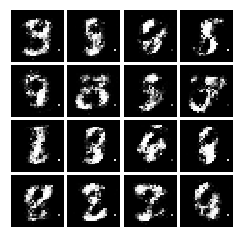

Iteration: 10100 - Discriminator Loss: 0.1782, Generator Loss: 2.603
Iteration: 10200 - Discriminator Loss: 0.2228, Generator Loss: 2.988
Iteration: 10300 - Discriminator Loss: 0.3046, Generator Loss: 3.216
Iteration: 10400 - Discriminator Loss: 0.1342, Generator Loss: 2.846
Iteration: 10500 - Discriminator Loss: 0.2094, Generator Loss: 3.51
Iteration: 10600 - Discriminator Loss: 0.1702, Generator Loss: 3.474
Iteration: 10700 - Discriminator Loss: 0.1241, Generator Loss: 3.221
Iteration: 10800 - Discriminator Loss: 0.2933, Generator Loss: 2.885
Iteration: 10900 - Discriminator Loss: 0.3912, Generator Loss: 3.527
Iteration: 11000 - Discriminator Loss: 0.1933, Generator Loss: 3.413


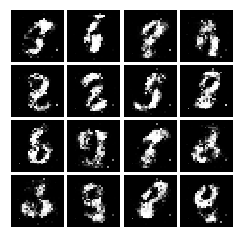

Iteration: 11100 - Discriminator Loss: 0.1644, Generator Loss: 3.2
Iteration: 11200 - Discriminator Loss: 0.1449, Generator Loss: 3.478
Iteration: 11300 - Discriminator Loss: 0.1988, Generator Loss: 3.218
Iteration: 11400 - Discriminator Loss: 0.3223, Generator Loss: 3.14
Iteration: 11500 - Discriminator Loss: 0.2391, Generator Loss: 2.741
Iteration: 11600 - Discriminator Loss: 0.3428, Generator Loss: 2.803
Iteration: 11700 - Discriminator Loss: 0.1635, Generator Loss: 3.196
Iteration: 11800 - Discriminator Loss: 0.3025, Generator Loss: 3.085
Iteration: 11900 - Discriminator Loss: 0.2204, Generator Loss: 3.534
Iteration: 12000 - Discriminator Loss: 0.1954, Generator Loss: 3.83


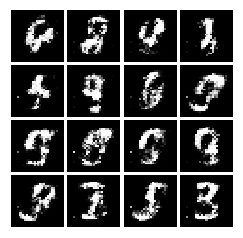

Iteration: 12100 - Discriminator Loss: 0.2529, Generator Loss: 3.153
Iteration: 12200 - Discriminator Loss: 0.2281, Generator Loss: 3.165
Iteration: 12300 - Discriminator Loss: 0.1587, Generator Loss: 3.676
Iteration: 12400 - Discriminator Loss: 0.2551, Generator Loss: 3.183
Iteration: 12500 - Discriminator Loss: 0.1694, Generator Loss: 2.929
Iteration: 12600 - Discriminator Loss: 0.1799, Generator Loss: 3.341
Iteration: 12700 - Discriminator Loss: 0.1924, Generator Loss: 2.964
Iteration: 12800 - Discriminator Loss: 0.2464, Generator Loss: 2.809
Iteration: 12900 - Discriminator Loss: 0.2936, Generator Loss: 3.087
Iteration: 13000 - Discriminator Loss: 0.1613, Generator Loss: 3.232


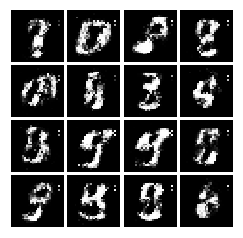

Iteration: 13100 - Discriminator Loss: 0.2551, Generator Loss: 2.977
Iteration: 13200 - Discriminator Loss: 0.1707, Generator Loss: 3.061
Iteration: 13300 - Discriminator Loss: 0.1819, Generator Loss: 2.952
Iteration: 13400 - Discriminator Loss: 0.1825, Generator Loss: 3.057
Iteration: 13500 - Discriminator Loss: 0.1626, Generator Loss: 2.922
Iteration: 13600 - Discriminator Loss: 0.231, Generator Loss: 2.68
Iteration: 13700 - Discriminator Loss: 0.3682, Generator Loss: 3.144
Iteration: 13800 - Discriminator Loss: 0.2318, Generator Loss: 2.889
Iteration: 13900 - Discriminator Loss: 0.4147, Generator Loss: 2.07
Iteration: 14000 - Discriminator Loss: 0.2339, Generator Loss: 2.938


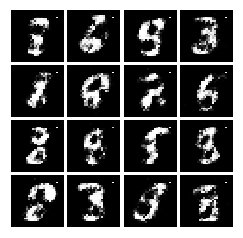

Iteration: 14100 - Discriminator Loss: 0.2563, Generator Loss: 3.066
Iteration: 14200 - Discriminator Loss: 0.3175, Generator Loss: 3.763
Iteration: 14300 - Discriminator Loss: 0.2555, Generator Loss: 2.757
Iteration: 14400 - Discriminator Loss: 0.3677, Generator Loss: 2.955
Iteration: 14500 - Discriminator Loss: 0.1671, Generator Loss: 2.926
Iteration: 14600 - Discriminator Loss: 0.2078, Generator Loss: 3.501
Iteration: 14700 - Discriminator Loss: 0.38, Generator Loss: 3.273
Iteration: 14800 - Discriminator Loss: 0.2233, Generator Loss: 3.189
Iteration: 14900 - Discriminator Loss: 0.2018, Generator Loss: 3.0
Iteration: 15000 - Discriminator Loss: 0.2562, Generator Loss: 2.88


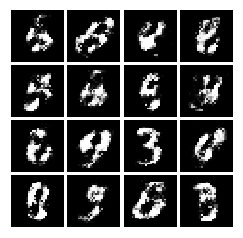

Iteration: 15100 - Discriminator Loss: 0.3078, Generator Loss: 2.636
Iteration: 15200 - Discriminator Loss: 0.3393, Generator Loss: 3.431


KeyboardInterrupt: 

In [16]:
for i in range(100000):
    x_batch, _ = mnist.train.next_batch(batch_size)
    z_batch = get_sample_z((batch_size, z_dim))
    c_batch = get_sample_c(batch_size)
    
    _, d_loss_val = sess.run(
        [d_step, d_loss],
        feed_dict={X: x_batch, z: z_batch, c: c_batch}
    )

    _, g_loss_val = sess.run(
        [g_step, g_loss],
        feed_dict={z: z_batch, c: c_batch}
    )
    
    sess.run([q_step], feed_dict={z: z_batch, c: c_batch})

    if i % 100 == 0:
        print('Iteration: {} - Discriminator Loss: {:.4}, Generator Loss: {:.4}'
              .format(i, d_loss_val, g_loss_val))

        if i % 1000 == 0:
            samples = sess.run(generator_sample, feed_dict={z: get_sample_z(size=(16, z_dim)),
                                                            c: get_sample_c(16)})

            fig = plot_images(samples)
            plot.show()
            plot.close(fig)